 

Data Source: 

https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources  

Training set: train folder 

Validation and Test set: valid folder 

Reference: https://cs230.stanford.edu/blog/split/  

Random seed: 24 

In [1]:
# Import modules
# Add modules as needed
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from keras.utils import to_categorical
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, LayerNormalization, GlobalMaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session


In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/MMAI_894/Team_Assignment/'
#!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources --path "/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# This function is just to get a list of dirs for the visualization and EDA functions
def define_paths(dir):
    filepaths = []
    labels = []
    #images = []
    folds = os.listdir(dir)
    print("The unique images labels are:", folds)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        print(foldpath)
        print(len(filelist),"files")
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    filepaths_array = np.array(filepaths)
    labels_array = np.array(labels)

    return filepaths_array, labels_array

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
filepaths_array, labels_array = define_paths(data_dir)
print(filepaths_array.shape)
print(labels_array.shape)
print(filepaths_array[-1])
print(labels_array[-1])


The unique images labels are: ['Early_blight', 'Bacterial_spot', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Early_blight
2452 files
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Bacterial_spot
2826 files
/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train/Late_blight
3113 files


KeyboardInterrupt: ignored

6
227 227 3
227 227 3
227 227 3
227 227 3
227 227 3
227 227 3


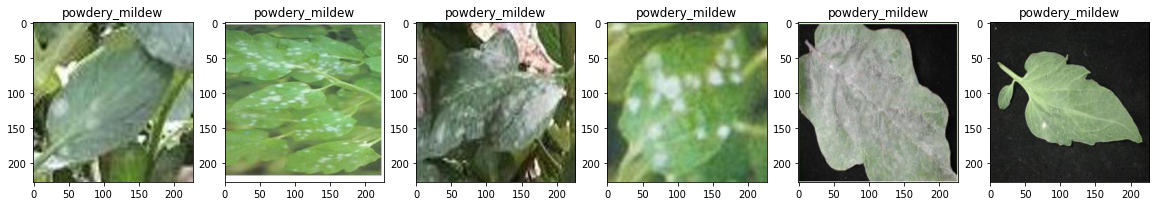

In [ ]:
def visualize(filepaths_array,labels_array):
  num_images = len(filepaths_array)
  fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(20,20))
  print(num_images)
# Display each image on a separate axis
  for i, images_array in enumerate(filepaths_array):
      #print(filepaths_array[i])
      image = mpimg.imread(filepaths_array[i])
      height, width, channels = image.shape
      ax[i].imshow(image)
      print(height, width, channels)
      #ax[i].set_xticks([])
      #ax[i].set_yticks([])
      ax[i].set_title(labels_array[i])

stop = len(filepaths_array)
start = stop-6

visualize(filepaths_array[start:stop], labels_array[start:stop])


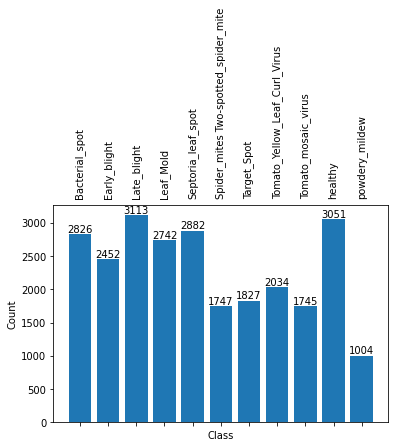

In [ ]:
def data_distribution(labels_array):
  # Get the count of each label
  unique_labels, counts = np.unique(labels_array, return_counts=True)

# Use a bar chart to show the distribution of labels
  bars = plt.bar(np.arange(len(counts)), counts)
  plt.xticks(np.arange(len(counts)), unique_labels, rotation=90)
  plt.tick_params(labeltop=True, labelbottom=False)
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.bar_label(bars, labels=counts, label_type='edge', fontsize=10)
  plt.show()

data_distribution(labels_array)


In [4]:
from tqdm import tqdm
from keras.applications.mobilenet_v2 import preprocess_input

# This functions builds a generator (allows for batch loading of the images to save on memory !this was the problem I initially had!)
#-> splits images into batches,
# Preprocess each image to be normalized to the mean and stddev of MobilenetV2 and scaled betwee [-1,1] as required by MobilenetV2,
# Reshapes each image to the specified pixel height and width,
# Extracts the category classes, 
# One hot encoded the catergories

def loadtrain_images(dir, params={}):

  data_dir = dir
  height=params['IMG_HEIGHT'] 
  width=params['IMG_WIDTH'] 
  random_seed = params['random_seed']
  batch_size = params['batch_size']

  data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  
  train_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='training',
      shuffle=True,
      seed=random_seed
  )
  return train_generator

def loadsplit_val_images(dir, params={}):

  data_dir = dir
  height=params['IMG_HEIGHT'] 
  width=params['IMG_WIDTH'] 
  data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.5)
  
  random_seed = 24
  batch_size = 128

  val_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='training',
      shuffle=True,
      seed=random_seed
  )
  
  test_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='validation',
      shuffle=True,
      seed=random_seed
  )
  return val_generator, test_generator


params= {'IMG_HEIGHT': 224, 'IMG_WIDTH': 224, 'batch_size':128, 'random_seed':24}

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
train_gen = loadtrain_images(data_dir, params=params) 

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
val_gen, test_gen = loadsplit_val_images(data_dir, params=params) 



total_samples = train_gen.samples + val_gen.samples + test_gen.samples
print("\nTotal number of samples:", total_samples)
print("Number of training image samples:", train_gen.samples)
print("Number of validation image samples:", val_gen.samples)
print("\nX_train % split:", train_gen.samples / total_samples*100,"%")
print("X_val % split:", val_gen.samples / total_samples*100,"%")
print("X_test % split:", test_gen.samples / total_samples*100,"%")
print("Batch size:", params['batch_size'])


Found 25423 images belonging to 11 classes.
Found 12714 images belonging to 11 classes.
Found 12709 images belonging to 11 classes.

Total number of samples: 50846
Number of training image samples: 25423
Number of validation image samples: 12714

X_train % split: 50.0 %
X_val % split: 25.004916807615153 %
X_test % split: 24.995083192384847 %
Batch size: 128


In [10]:
clear_session()

def build_model_CNN():
  
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size = (4, 4), activation = 'relu', input_shape=(256, 256, 3),strides = (1,1), padding = "same", name="Convolution_Layer1"))
    model.add(layers.MaxPool2D(2,2))
    model.add(Conv2D(filters=64, kernel_size=(4, 4), activation = 'relu', strides=(1,1), padding="same", name="Convolution_Layer2"))
    model.add(layers.MaxPool2D(2,2))
    model.add(Conv2D(64, (4, 4), activation = 'relu', strides=(1,1), padding="same",name="Convolution_Layer3"))
    model.add(layers.Flatten(name="Flatten_layer"))

    
    #Layer 1 with 64 nodes and relu activation. Input will get calcualted by Keras
    # A single Dense layer looked to give suffecient performance as compared to adding two layers i.e. not too much benefit was observed in this case by having two dense layers
    #model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), name="Layer_1"))
    #Add dropout of 0.30 (this number was arrived upon via hyperparameter tuning)
    model.add(Dropout(0.30))
    #Added an Batch normalization layer to help improve performance - this didn't help
    #model.add(BatchNormalization())
    #Output with softmax activation and 11 out out layers corresponding to the output classes
    model.add(Dense(11, activation='softmax',  name="Output"))
    #Lets see how the model looks
    model.summary()   
    print(model.get_layer("Flatten_layer").output_shape)

    return model

model_CNN = build_model_CNN()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution_Layer1 (Conv2D)  (None, 256, 256, 32)     1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 Convolution_Layer2 (Conv2D)  (None, 128, 128, 64)     32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 Convolution_Layer3 (Conv2D)  (None, 64, 64, 64)       65600     
                                                                 
 Flatten_layer (Flatten)     (None, 262144)            0

In [5]:
#Lets do transfer learning using a baseline model of MobilenetV2
from tensorflow.keras.applications import MobileNetV2

clear_session()
def build_model_MobileNetV2():
    
    #Pre-Trained transfer learning network or the base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    #Classification head
    model = Sequential()
    model.add(base_model)
    model.add(GlobalMaxPooling2D())
    # Layer 1 with 64 nodes and relu activation. Input will get calcualted by Keras
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), name="Class_Layer_1"))
    # Add dropout of 0.30 (this number was arrived upon via hyperparameter tuning)
    model.add(Dropout(0.30))
    # Added an Batch normalization layer to help improve performance
    model.add(BatchNormalization())
    model.add(Dense(11, activation='softmax', name='Output_Layer'))

    model.summary()
    return model

model_MobileNetV2 = build_model_MobileNetV2()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 Class_Layer_1 (Dense)       (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                             

In [6]:
def compile_model(model):
  
    #Lets try different optimizers as well as learning rates to see if it helps
    optimizer = Adam()
    #optimizer = Adam(learning_rate=0.001)
    #optimizer = RMSprop()
    loss = CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

#model_CNN = compile_model(model_CNN)
model_MobileNetV2 = compile_model(model_MobileNetV2)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [7]:
def train_model(model, XY_train, XY_val, batch_size, epochs):
  
      # Lets add early stopping if the val loss doesn't improve after 3 epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
    checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, mode='min')

    # Using 12-20 epochs and including validation data. Also added verbose to monitor output with early stopping. 
    # Can use early stopping as well buthave it commented out for this instance
    # history = model.fit(X_train, Y_train, epochs=20, batch_size=64,verbose=1, validation_data=(X_val, Y_val), callbacks=[early_stopping, checkpoint])
    history = model.fit(XY_train, steps_per_epoch=XY_train.samples // batch_size,
                        epochs=epochs, batch_size=batch_size, verbose=1, 
                        validation_data=(XY_val), validation_steps=XY_val.samples // batch_size,
                        callbacks=[early_stopping, checkpoint])

    return model, history

clear_session()
#Comment and uncomment the model you want to run i.e. CNN or Transferlearning from MobilenetV2

#model = model_CNN
model = model_MobileNetV2
model, history = train_model(model, train_gen, val_gen, batch_size=128, epochs=12)

Epoch 1/12
198/198 [==============================] - 4950s 25s/step - loss: 1.2742 - accuracy: 0.6223 - val_loss: 0.8684 - val_accuracy: 0.7551
Epoch 2/12
198/198 [==============================] - 177s 893ms/step - loss: 0.8345 - accuracy: 0.7594 - val_loss: 0.7134 - val_accuracy: 0.8077
Epoch 3/12
198/198 [==============================] - 177s 894ms/step - loss: 0.7254 - accuracy: 0.7944 - val_loss: 0.6805 - val_accuracy: 0.8112
Epoch 4/12
198/198 [==============================] - 177s 893ms/step - loss: 0.6471 - accuracy: 0.8144 - val_loss: 0.5620 - val_accuracy: 0.8365
Epoch 5/12
198/198 [==============================] - 176s 891ms/step - loss: 0.6241 - accuracy: 0.8222 - val_loss: 0.5431 - val_accuracy: 0.8618
Epoch 6/12
198/198 [==============================] - 177s 895ms/step - loss: 0.6051 - accuracy: 0.8261 - val_loss: 0.5229 - val_accuracy: 0.8643
Epoch 7/12
198/198 [==============================] - 177s 895ms/step - loss: 0.5932 - accuracy: 0.8288 - val_loss: 0.4662 - 

In [8]:
model.save('/content/drive/MyDrive/MMAI_894/Team_Assignment/MobilenetV2_with_simple_classificationhead.h5')

In [ ]:
model.load('/content/drive/MyDrive/MMAI_894/Team_Assignment/MobilenetV2_with_simple_classificationhead.h5')

NameError: ignored

In [9]:
def eval_model(model, test_generator):
    # TODO: evaluate the model
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    model.load_weights('best_weights.h5')
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    return test_loss, test_accuracy


test_loss, test_accuracy = eval_model(model, test_gen)
# added this line as want to see what the predicted classification for an input of X_test is
#output = model.predict(X_test)

print("\nTest data set Accuracy = ", test_accuracy*100,"%")
print("Test data set Loss = ", test_loss*100,"%")

100/100 [==============================] - 54s 541ms/step - loss: 0.3252 - accuracy: 0.9257

Test data set Accuracy =  92.57219433784485 %
Test data set Loss =  32.51860439777374 %


In [10]:
output = model.predict(test_gen)
Y_true = test_gen.classes

100/100 [==============================] - 54s 529ms/step


In [11]:
#class_names = {v: k for k, v in test_gen.class_indices.items()}
#Y_true_class_names = [class_names[label] for label in Y_true]
print(train_gen.class_indices)
print(Y_true.shape)

{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}
(12709,)
[0 0 0 ... 8 8 8]


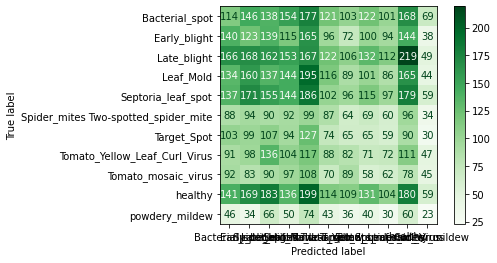

In [16]:
def confusion_mtrx(output, Y_true, class_labels):
  Y_predicted = np.argmax(output, axis=1)
  conf_mtx = confusion_matrix(Y_true, Y_predicted)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=class_labels)
  # Plot confusion matrix
  disp.plot(cmap='Greens')
  # Show plot
  plt.show()
class_labels = train_gen.class_indices
confusion_mtrx(output, Y_true, class_labels)

#Everything after this is either depracated or experimaental

In [ ]:
from tqdm import tqdm
from keras.applications.mobilenet_v2 import preprocess_input

# This functions builds a generator -> splits images into batches, normalizes each image, reshapes each image to the specified size, extracts the category classes, one hot encoded the catergories
def loadandsplit_images(dir, params={}):

  data_dir = dir
  height=params['IMG_HEIGHT'] 
  width=params['IMG_WIDTH'] 
  data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.5)
  
  random_seed = 24
  batch_size = 128

  train_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='training',
      shuffle=True,
      seed=random_seed
  )
  
  val_generator = data_datagen.flow_from_directory(
      data_dir,
      target_size = (height,width),
      color_mode='rgb',
      batch_size = batch_size,
      class_mode = 'categorical',
      subset='validation',
      shuffle=True,
      seed=random_seed
  )

  total_samples = train_generator.samples + val_generator.samples
  print("\nTotal number of samples:", total_samples)
  print("Number of training image samples:", train_generator.samples)
  print("Number of validation image samples:", val_generator.samples)
  print("\nX_train % split:", train_generator.samples / total_samples*100,"%")
  print("X_val % split:", val_generator.samples / total_samples*100,"%")
  print("Batch size:", batch_size)


  return train_generator, val_generator

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
params= {'IMG_HEIGHT': 224, 'IMG_WIDTH': 224}
train_gen, val_gen = loadandsplit_images(data_dir, params=params) 



Found 12714 images belonging to 11 classes.
Found 12709 images belonging to 11 classes.

Total number of samples: 25423
Number of training image samples: 12714
Number of validation image samples: 12709

X_train % split: 50.009833615230306 %
X_val % split: 49.990166384769694 %
Batch size: 128


In [ ]:
from tqdm import tqdm
from keras.applications.mobilenet_v2 import preprocess_input

# This functions builds a generator -> splits images into batches, normalizes each image, reshapes each image to the specified size, extracts the category classes, one hot encoded the catergories
def loadandsplit_images(dir, train_or_val, params={}):

  data_dir = dir
  height=params['IMG_HEIGHT'] 
  width=params['IMG_WIDTH'] 
  random_seed = params['random_seed']
  batch_size = params['batch_size']

  if train_or_val == 'val':
    data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.5)
    val_iterator = data_datagen.flow_from_directory(
                   data_dir,
                   target_size = (height,width),
                   color_mode='rgb',
                   batch_size = batch_size,
                   class_mode = 'categorical',
                   subset='training',
                   shuffle=True,
                   seed=random_seed
                  )
    print("\nTotal number of Validation samples:", val_iterator.samples)
    test_iterator = data_datagen.flow_from_directory(
                   data_dir,
                   target_size = (height,width),
                   color_mode='rgb',
                   batch_size = batch_size,
                   class_mode = 'categorical',
                   subset='validation',
                   shuffle=True,
                   seed=random_seed
                  )
    print("\nTotal number of pseudo_Test samples:", test_iterator.samples)
    return val_iterator, test_iterator
  elif train_or_val == 'train':
    data_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_iterator = data_datagen.flow_from_directory(
                    data_dir,
                    target_size = (height,width),
                    color_mode='rgb',
                    batch_size = batch_size,
                    class_mode = 'categorical',
                    subset='training',
                    shuffle=True,
                    seed=random_seed
                    )
    print("\nTotal number of Training samples:", train_iterator.samples)
    return train_iterator
    
  else:
    return
    

params= {'IMG_HEIGHT': 224, 'IMG_WIDTH': 224, 'batch_size':128, 'random_seed':24}

#train_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
#train_gen = loadandsplit_images(train_dir, train_or_val='train', params=params) 

val_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
val_gen, test_gen = loadandsplit_images(val_dir, train_or_val='val', params=params)

In [ ]:
#you don't need this as the generator automatically one hot encoded the labels

def one_hot_data(train_data, val_data):

  _ , batch_labels = next(train_data)
  print(batch_labels)
  train_labels = train_data.classes
  classes = train_data.num_classes
  one_hot_train_labels = to_categorical(train_labels, num_classes=classes)
   
  val_labels = train_data.classes
  one_hot_val_labels = to_categorical(val_labels, num_classes=classes)
   



  return one_hot_train_labels, one_hot_val_labels


Y_train, Y_val = one_hot_data(train_gen, val_gen)
print(Y_train.shape)
print(Y_train[12713])

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(12714, 11)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
# This function is depracted and is replaced by function load_images_keras.
# Just left here for debug in case needed

from tqdm import tqdm
import cv2 as Cv2

def load_images(dir):
    filepaths = []
    labels = []
    images = []
    heights = []
    widths = []
    channels = []
    
    folds = os.listdir(dir)
    print("The unique images labels are:", folds,"\n\n")
    print(folds)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        print(foldpath," files in folder")
        print(len(filelist),"files in folder")
        num_images_loaded = 0      
        for file in tqdm(filelist):
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img = Cv2.imread(fpath)
                    height,width,channels = img.shape
                    heights.append(height)
                    widths.append(width)
                    #images.append(np.array(img))
                    num_images_loaded += 1
                    pass
                    #img.close()
              #img = mpimg.imread(fpath, file)
              #images.append(img)
                except Exception as e:
                    print(f"Error opening image: {e}")
            else:
                print(f"{file} is not a .jpg file")
        #num_images_loaded = len(images)
        print(num_images_loaded,"files loaded for a total of", len(images)," in memory")
             

    filepaths_array = np.array(filepaths)
    labels_array = np.array(labels)
    images_array = images
    heights_array = np.array(heights)
    widths_array = np.array(widths)
    print("Maxheight:",heights_array.max)
    print("MaxWidth:",widths_array.max)
    return filepaths_array, labels_array, images_array

data_dir = ('/content/drive/MyDrive/MMAI_894/Team_Assignment/Dataset/tomato-disease-multiple-sources_Data/train')
filepaths_array, labels_array, images_array = load_images(data_dir)

print("Total number of files paths loaded: ",filepaths_array.shape)
print("Total number of labels loaded: ",labels_array.shape)
print("Total number of images loaded: ",len(images_array))

   

In [ ]:
"""
from PIL import Image
            if file.endswith('.jpg'):
                try:
                  #with Image.open(fpath) as img:
                    height,width = img.size
                    heights.append(height)
                    widths.append(width)
                    images.append(np.array(img))
                    
                    pass
                    #img.close()
"""       

"\nfrom PIL import Image\n            if file.endswith('.jpg'):\n                try:\n                  #with Image.open(fpath) as img:\n                    height,width = img.size\n                    heights.append(height)\n                    widths.append(width)\n                    images.append(np.array(img))\n                    \n                    pass\n                    #img.close()\n"

In [ ]:
def split_data(cleaned_X, cleaned_Y):
    # TODO: split the data
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    # TODO: split the data into validation, test, and train datasets
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION
    #Lets do a 50% splits first and also force the data to be shuffled to prevent bias

    random_seed = 24
    X_train, X_val, Y_train, Y_val = train_test_split(cleaned_X, cleaned_Y, train_size= 0.5, test_size=0.5, random_state=random_seed,shuffle=True)
    return X_val, X_train, Y_val, Y_train

cleaned_X = filepaths_array
cleaned_Y = labels_array
X_val, X_train, Y_val, Y_train = split_data(cleaned_X, cleaned_Y)



print("X_train_shape:", X_train.shape)
print("X_validation_shape:", X_val.shape)
#print("Xtest_shape:", X_test.shape)

#Lets check % of splits
print("\nX_train % split:", X_train.shape[0] / cleaned_X.shape[0]*100,"%")
print("X_val % split:", X_val.shape[0] / cleaned_X.shape[0]*100,"%")
#print("X_test % split:", X_test.shape[0] / cleaned_X.shape[0]*100,"%")

In [ ]:
def clean_data(raw_X, raw_Y):
    # TODO: clean and QA raw_X and raw_Y
    # DO NOT CHANGE THE INPUTS OR OUTPUTS TO THIS FUNCTION

    # Lets normalize the data here
    shapes = [image.shape for image in raw_X]
    print(shapes)
    
    arrays = [np.array(raw_X) for images in raw_X]
    data = np.stack(arrays, axis=0)
    #normalized_data_X = raw_X / 255
    reshaped_img = raw_X.values.reshape(-1,256,256,3)

    #cleaned_X = np.stack(raw_X, axis = 0)
    # One hot encode Y
    label_map = {label: i for i, label in enumerate(set(raw_Y))}
    labels_encoded = [label_map[label] for label in labels]
    cleaned_Y = to_categorical(labels_encoded)

    return cleaned_X, cleaned_Y


cleaned_X, cleaned_Y = clean_data(images_array, labels_array)
print(cleaned_X.shape)
print(cleaned_Y.shape)